In [1]:
#import ipynb
#from src import sqlite_df_fn 

from ipynb.fs.defs.sqlite_df_fn3 import *
import rpy2.rinterface
%load_ext rpy2.ipython

# Quering data

Obtain two groups to compare 

In [2]:
df = getdata(query_str(), "Recovered", 50)

# Data Cleaning

Loading R libraries

In [3]:
%%R
library(data.table)
library(universalmotif)
library(motifStack)
library(yaml)

R[write to console]: data.table 1.13.6 using 2 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 

R[write to console]: Loading required package: grImport2

R[write to console]: Loading required package: grid

R[write to console]: Loading required package: MotIV

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    any

In [4]:
%%R -i df
library(universalmotif)
setDT(df)# data frame  to data table
# remove blank sequences
dt_clean <- df[junction_aa!=""]
#remove rows with *-containing junction_aa
seq_meta_dt_1_clean_clean <- dt_clean[!grepl(pattern = "\\*",dt_clean$junction_aa),]
# Subset rows with the mode length of the junction_aa sequence
#function
seq_length <- function(dt_disease_stage,length){
seq <- seq_meta_dt_1_clean_clean$junction_aa[
    nchar(seq_meta_dt_1_clean_clean$junction_aa) == length]
    return(seq)
    }
#nchar(seq_meta_dt_1_clean_clean[1]$junction_aa)
#nchar(seq_meta_dt_1_clean_clean$junction_aa#[1])
seq <- seq_length(seq_meta_dt_1_clean_clean, 15)


# Junction_aa motif analysis

select sequence length for generating motif

In [5]:
%%R
seq <- seq_length(seq_meta_dt_1_clean_clean, 15)

Create motif using universal motif and write to temp file

In [6]:
%%R
# create motif using universalmotif
motif1 <- create_motif(seq, alphabet = "AA")
PCM = convert_type(motif1, "PCM")
# transform motif to matrix written 
# to temp file to read using motifStack for visualziation 
write_matrix(PCM, 'pcm0', overwrite = TRUE, rownames = TRUE, header = FALSE)
write_motifs(motif1, 'pcm0_motif', overwrite = TRUE)

Load motif and reformat

In [7]:
%%R
library(yaml)
motif_con <- read_yaml('motif13')[8]
pcm <- read.table("pcm0", header = FALSE, row.names = 1)
motif_con <- read_yaml('pcm0_motif')[8]
names(pcm) <- strsplit(motif_con[[1]], split = "")[[1]]
pcm_mat = as.matrix(pcm)

Visualize motif with MotifStack

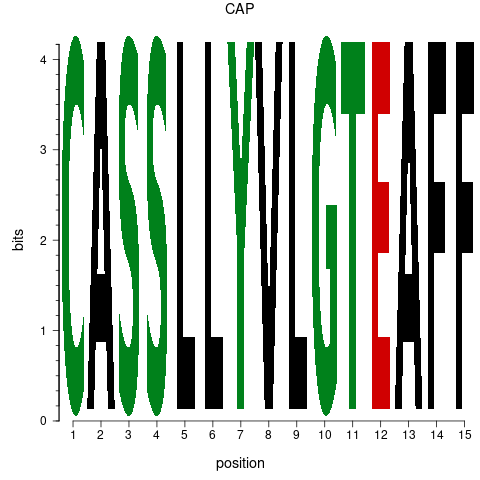

In [8]:
%%R 

motif<-new("pcm", mat=pcm_mat, name="CAP", 
            color=colorset(alphabet="AA",colorScheme="chemistry"))
#pfm <- pcm2pfm()
plot(motif)


Visualize multiple motifs from different clinical groups

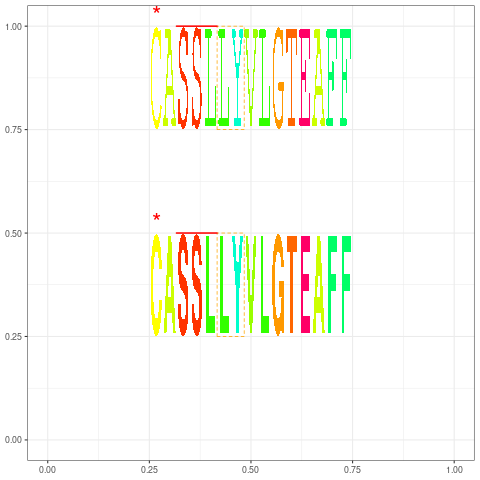

In [9]:
%%R

markerRect <- new("marker", type="rect", start=6, stop=7, gp=gpar(lty=2, fill=NA, col="orange"))
markerLine <- new("marker", type="line", start=3, stop=5, gp=gpar(lwd=2, col="red"))
markerText <- new("marker", type="text", start=1, label="*", gp=gpar(cex=2, col="red"))
motif <- new("pcm", mat=pcm_mat, name="bin_SOLEXA", 
             markers=c(markerRect, markerLine, markerText))
pfm <- pcm2pfm(motif)
df <- data.frame(xmin=c(.25, .25), ymin=c(.25, .75), xmax=c(.75, .75), ymax=c(.5, 1), 
                 fontfamily=c("Helvetica", "mono,Courier"), fontface=c(2, 1))
df$motif <- list(pfm, pfm)

library(ggplot2)

ggplot(df, aes(xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, motif=motif, 
               fontfamily=fontfamily, fontface=fontface)) + 
    geom_motif() + theme_bw() + ylim(0, 1) + xlim(0, 1)

